# Getting started

In [1]:
import os
import datetime as dt
import pandas as pd
import xarray as xr
import hatyan
hatyan.close('all')

# optionally set logging level/format (and stream to prevent red background)
import logging, sys
logging.basicConfig(level="INFO", format='%(message)s', stream=sys.stdout)

In [2]:
# defining a list of the components to be analysed ()'year' contains 94 components and the mean H0)
const_list = hatyan.get_const_list_hatyan('year')


In [3]:
# reading and editing time series (Cuxhaven dataset from UHSLC database)
# results in a pandas DataFrame a 'values' column (water level in meters) and a pd.DatetimeIndex as index
file_data_meas = 'http://uhslc.soest.hawaii.edu:80/opendap/rqds/global/hourly/h825a.nc'
times_pred = slice("2017-01-01", "2018-12-31", "10min")
ts_data = xr.open_dataset(file_data_meas)
ts_data_sel = ts_data.sea_level.isel(record_id=0).sel(time=slice(times_pred.start,times_pred.stop))
# correct from mm to meters and for 5m offset
ts_data_sel = (ts_data_sel/1000-5)
ts_meas = pd.DataFrame({'values':ts_data_sel.to_series()})
ts_meas.attrs['eenheid'] = 'm' # required for hatyan.plot_HWLW_validatestats()


In [4]:
# inspect ts_meas
print(ts_meas)


                            values
time                              
2017-01-01 00:00:00.000000    1.56
2017-01-01 01:00:00.028800    1.85
2017-01-01 01:59:59.971200    1.95
2017-01-01 03:00:00.000000    1.68
2017-01-01 04:00:00.028800    1.02
...                            ...
2018-12-31 19:00:00.028800    1.37
2018-12-31 19:59:59.971200    1.36
2018-12-31 21:00:00.000000    1.02
2018-12-31 22:00:00.028800    0.49
2018-12-31 22:59:59.971200   -0.04

[17520 rows x 1 columns]


ANALYSIS initializing
nodalfactors         = True
fu_alltimes          = True
xfac                 = False
source               = schureman
return_allperiods    = True
analysis_perperiod   = Y
max_matrix_condition = 12

n components analyzed  = 95
analysis_perperiod=Y, separate periods are automatically determined from timeseries
analyzing 2017 of sequence ['2017', '2018']
#timesteps    = 8760
tstart        = 2017-01-01 00:00:00
tstop         = 2017-12-31 22:59:59
timestep      = None
percentage_nan in values_meas_sel: 0.00%
nodal factors (f and u) are calculated for all timesteps
folding frequencies over Nyquist frequency, which is half of the dominant timestep (1.000008 hour), there are 2 unique timesteps)
Rayleigh criterion OK (always>0.70, minimum is 1.00)
Frequencies are far enough apart (always >0.000080, minimum is 0.000114)
calculating xTx matrix
condition of xTx matrix: 3.91
matrix system solved, elapsed time: 0:00:00.032999
analyzing 2018 of sequence ['2017', '2018']
#timeste

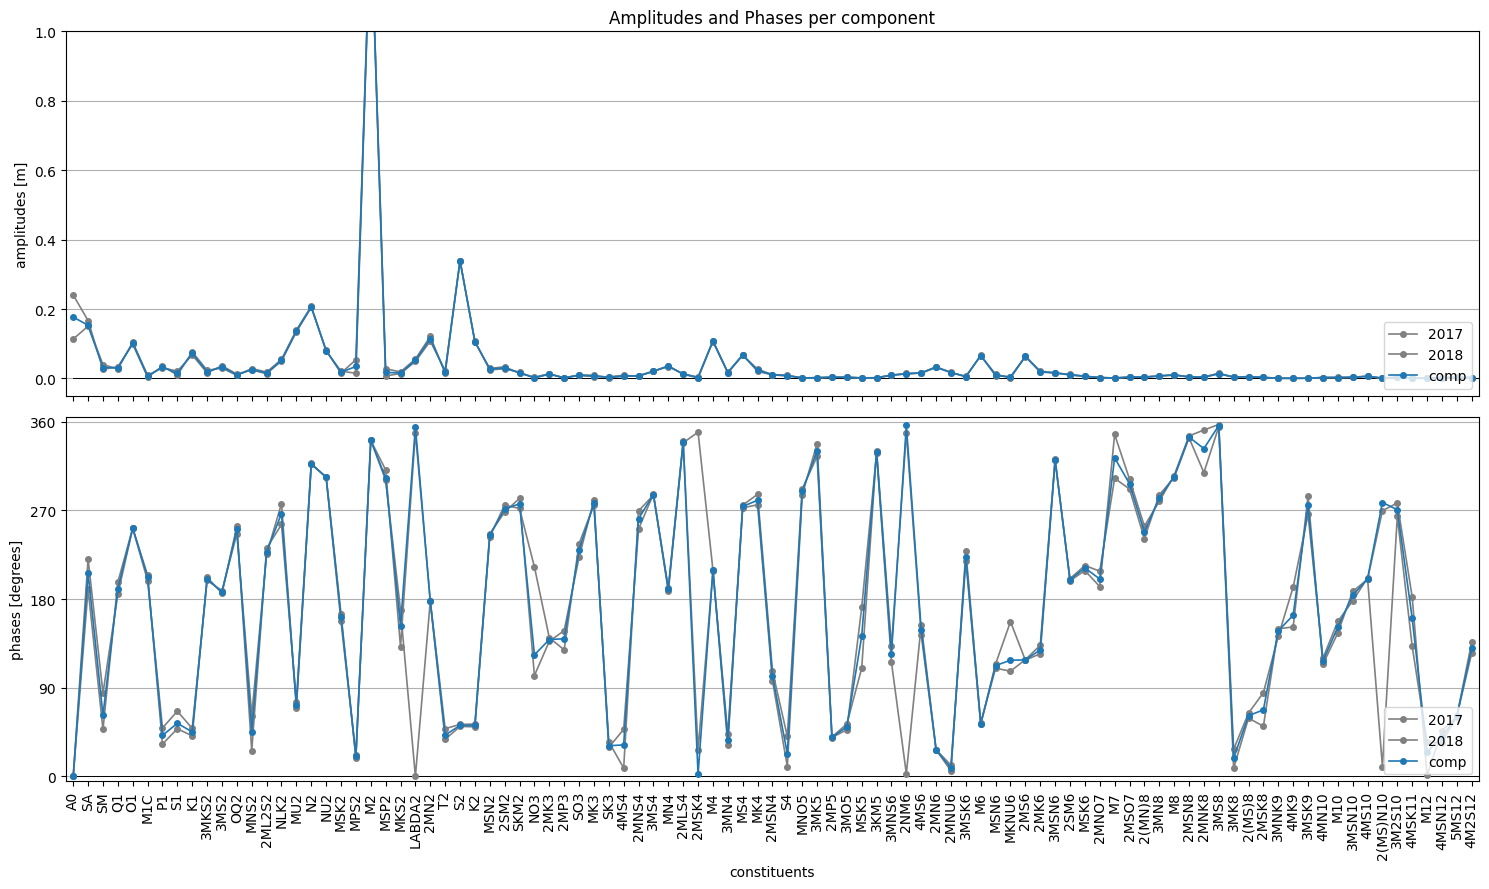

In [5]:
# tidal analysis and plotting of results 
comp_mean, comp_allperiods = hatyan.analysis(ts=ts_meas, const_list=const_list, 
                                               nodalfactors=True, return_allperiods=True,
                                               fu_alltimes=True, analysis_perperiod='Y')
fig,(ax1,ax2) = hatyan.plot_components(comp=comp_mean, comp_allperiods=comp_allperiods)
# fig.savefig('components.png')


In [6]:
# inspect comp_mean and comp_allyears
print(comp_mean)
print()
print(comp_allperiods)


               A     phi_deg
A0      0.176858    0.000000
SA      0.153059  206.352718
SM      0.031470   62.168109
Q1      0.030315  190.476712
O1      0.101746  252.005336
...          ...         ...
4MSK11  0.000476  160.765196
M12     0.000793   24.764564
4MSN12  0.002452   39.906165
5MS12   0.003327   60.882951
4M2S12  0.002401  130.187075

[95 rows x 2 columns]

               A               phi_deg            
time        2017      2018        2017        2018
A0      0.240297  0.113419    0.000000    0.000000
SA      0.166644  0.150657  220.841343  190.287113
SM      0.026262  0.039924   84.537364   47.670396
Q1      0.033770  0.027204  185.017161  197.259545
O1      0.099037  0.104456  251.875093  252.128823
...          ...       ...         ...         ...
4MSK11  0.000594  0.000455  182.289227  132.175117
M12     0.000491  0.001154    1.256283   34.528868
4MSN12  0.002322  0.002609   46.207175   34.300122
5MS12   0.002982  0.003671   60.628755   61.089440
4M2S12  0.002186

PREDICTION initializing
nodalfactors         = True
fu_alltimes          = True
xfac                 = False
source               = schureman

prediction() atonce
components used = 95
tstart = 2017-01-01 00:00:00
tstop = 2018-12-31 00:00:00
timestep = <10 * Minutes>
nodal factors (f and u) are calculated for all timesteps
PREDICTION started
PREDICTION finished


(-0.5, 0.5)

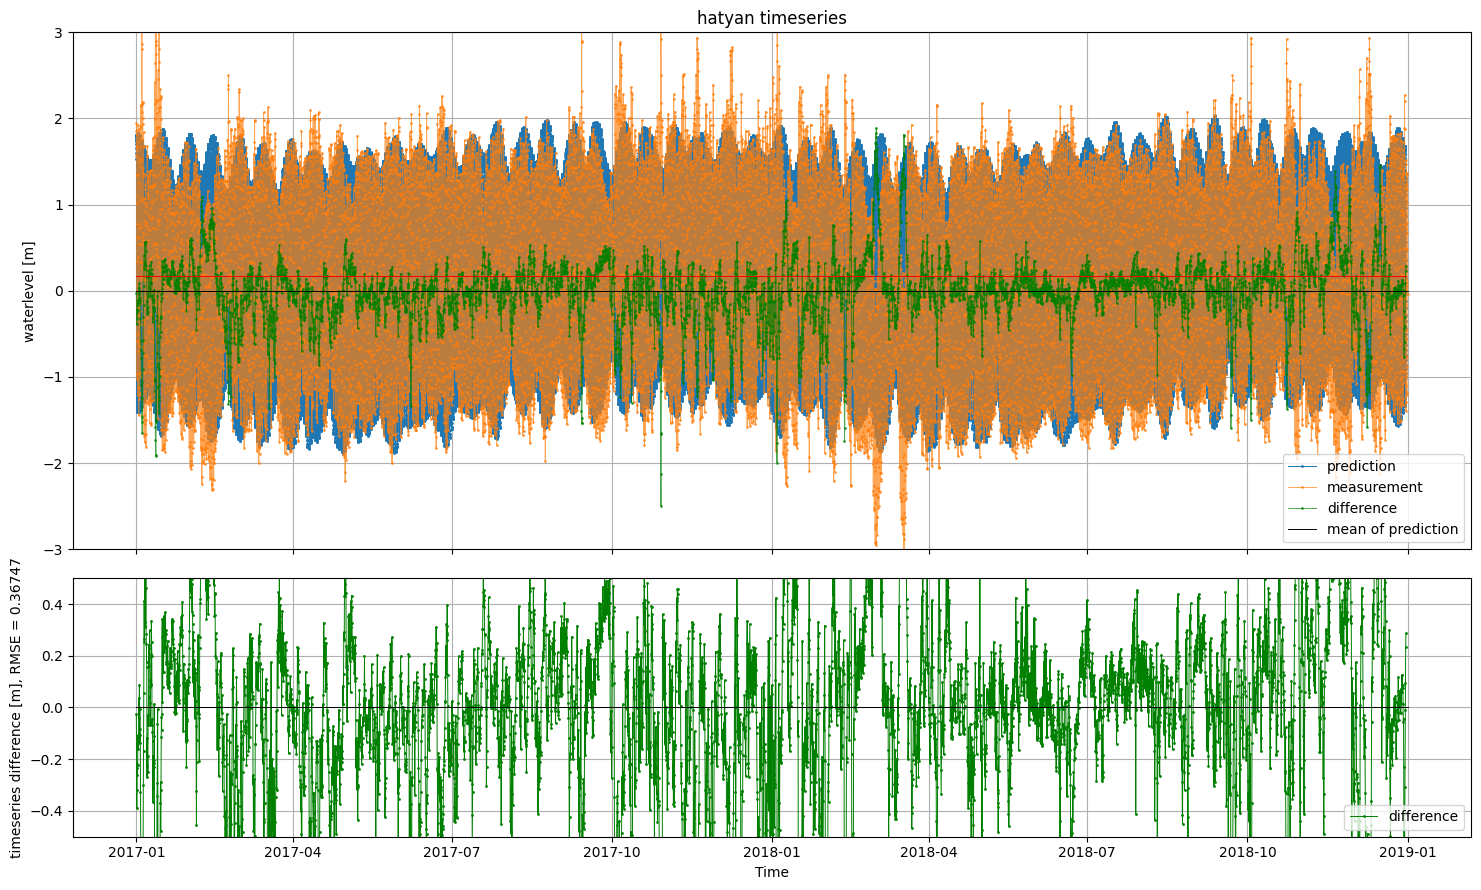

In [7]:
# tidal prediction and plotting of results (prediction settings are derived from the components dataframe)
ts_prediction = hatyan.prediction(comp=comp_mean, times=times_pred)
fig, (ax1,ax2) = hatyan.plot_timeseries(ts=ts_prediction, ts_validation=ts_meas)
ax1.legend(['prediction','measurement','difference','mean of prediction'])
ax2.set_ylim(-0.5,0.5)
# fig.savefig('prediction.png')


the timestep of the series for which to calculate extremes/HWLW is 60.00 minutes, but 1 minute is recommended
the timestep of the series for which to calculate extremes/HWLW is 10.00 minutes, but 1 minute is recommended


(-1.0, 1.0)

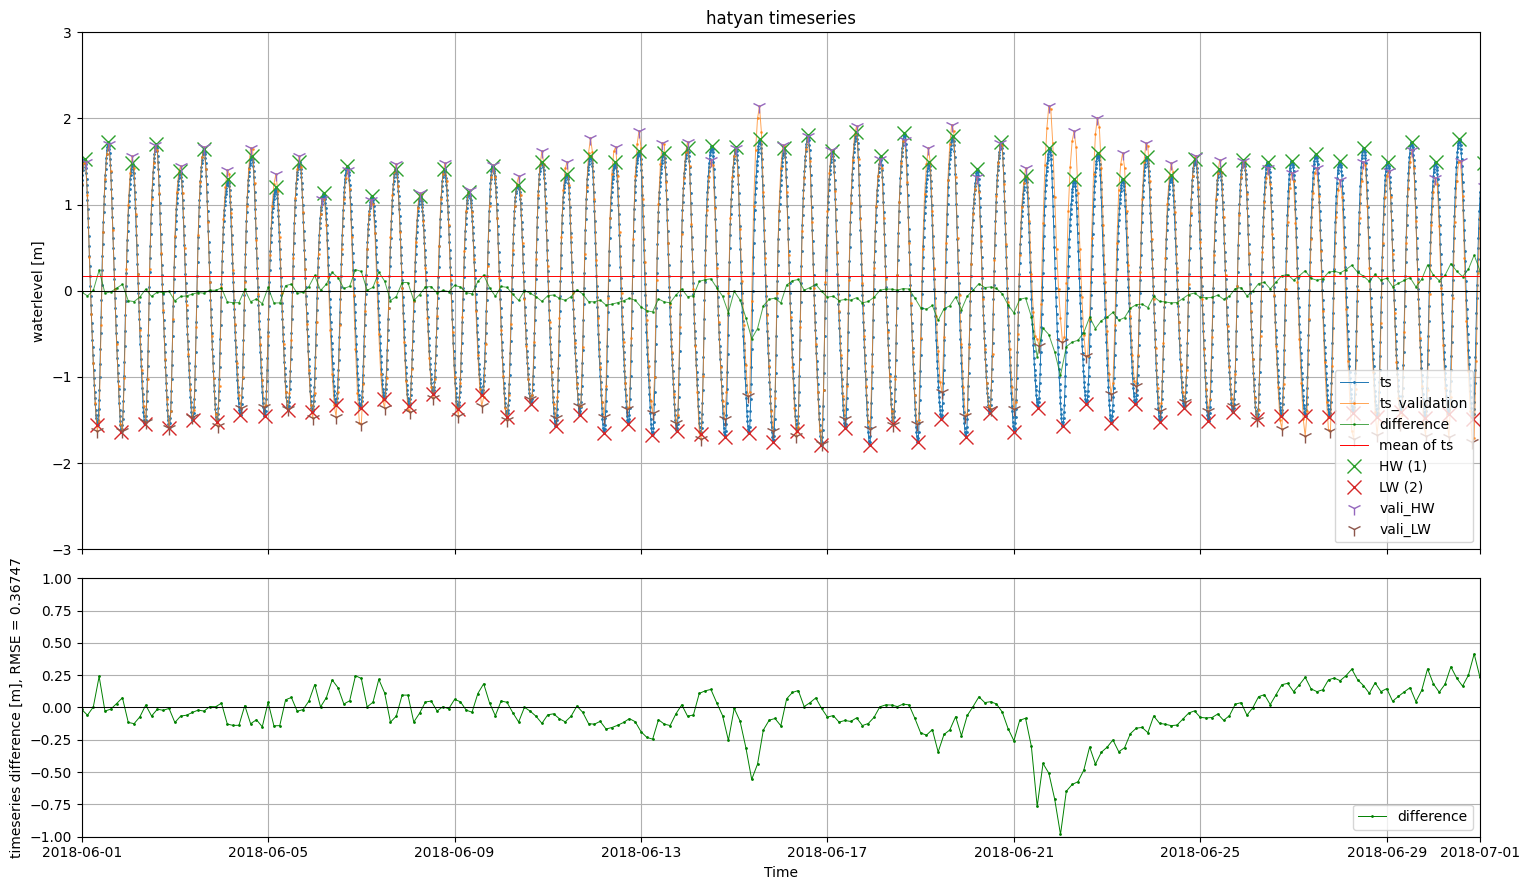

In [8]:
# calculation of HWLW and plotting of results
ts_ext_meas = hatyan.calc_HWLW(ts=ts_meas)
ts_ext_prediction = hatyan.calc_HWLW(ts=ts_prediction)
fig, (ax1,ax2) = hatyan.plot_timeseries(ts=ts_prediction, ts_validation=ts_meas, 
                                        ts_ext=ts_ext_prediction, ts_ext_validation=ts_ext_meas)
ax1.set_xlim(dt.datetime(2018,6,1),dt.datetime(2018,7,1))
ax2.set_ylim(-1,1)
# fig.savefig('prediction_HWLW.png')


In [9]:
# inspect ts_prediction and ts_ext_meas
print(ts_prediction)
print()
print(ts_ext_meas)


                       values
2017-01-01 00:00:00  1.535376
2017-01-01 00:10:00  1.598562
2017-01-01 00:20:00  1.652854
2017-01-01 00:30:00  1.698293
2017-01-01 00:40:00  1.735167
...                       ...
2018-12-30 23:20:00 -0.801245
2018-12-30 23:30:00 -0.855617
2018-12-30 23:40:00 -0.907682
2018-12-30 23:50:00 -0.957087
2018-12-31 00:00:00 -1.003177

[104977 rows x 1 columns]

                            values  HWLWcode  prominences    widths
times                                                              
2017-01-01 09:00:00.000000   -1.02         2         2.84  5.715404
2017-01-01 13:59:59.971200    1.82         1         2.84  6.345138
2017-01-01 21:00:00.000000   -1.21         2         3.14  5.703539
2017-01-02 01:59:59.971200    1.93         1         3.14  6.630230
2017-01-02 09:00:00.000000   -1.44         2         3.39  5.983549
...                            ...       ...          ...       ...
2018-12-30 13:00:00.028800   -1.07         2         2.26  5.130510


Calculating comparison statistics for extremes
HWLWno is not present in ts_ext or ts_ext_validation, trying to automatically derive it without station argument (this might fail)
ANALYSIS initializing
nodalfactors         = True
fu_alltimes          = True
xfac                 = False
source               = schureman
return_allperiods    = False
analysis_perperiod   = False
max_matrix_condition = 250

n components analyzed  = 1
#timesteps    = 2815
tstart        = 2017-01-01 08:30:00
tstop         = 2018-12-30 12:40:00
timestep      = None
percentage_nan in values_meas_sel: 0.00%
nodal factors (f and u) are calculated for all timesteps
folding frequencies over Nyquist frequency, which is half of the dominant timestep (5.666666666666667 hour), there are 14 unique timesteps)
calculating xTx matrix
condition of xTx matrix: 7.72
matrix system solved, elapsed time: 0:00:00.000520
ANALYSIS finished
no value or None for argument M2phasediff provided, automatically calculated correction w.r.t. 

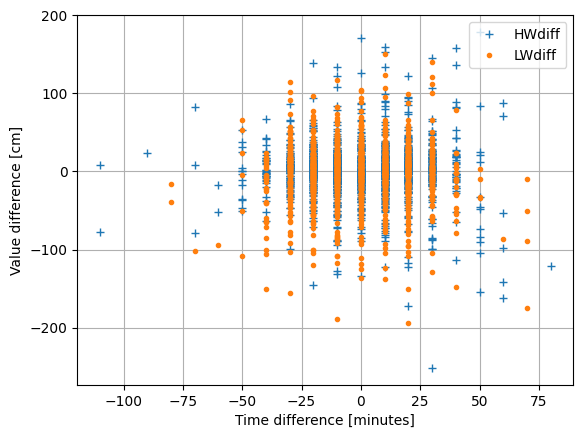

In [10]:
fig, ax = hatyan.plot_HWLW_validatestats(ts_ext=ts_ext_prediction, ts_ext_validation=ts_ext_meas)
# fig.savefig('prediction_HWLW_validatestats.png')
# ts_prediction.attrs["station"] = "Cuxhaven"
# ts_prediction.attrs["vertref"] = "MSL"
# ts_ext_prediction.attrs["station"] = "Cuxhaven"
# ts_ext_prediction.attrs["vertref"] = "MSL"
# hatyan.write_netcdf(ts=ts_prediction, ts_ext=ts_ext_prediction, filename='prediction.nc')
